In [17]:
# baseline model with data augmentation for the Computer Vision Hackathon (Emergency and Non Emergency dataset)
import sys
import tensorflow as tf
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import timeit

start = timeit.default_timer()


tf.test.gpu_device_name()


Using TensorFlow backend.


'/device:GPU:0'

In [0]:
#!cp -r /content/drive/My\ Drive/ComputerVisionHackathon/data /content/sample_data/
#!rm -rf /content/sample_data/data/train/.ipynb_checkpoints


In [0]:
#!mv /content/sample_data/data/train/emer/112.jpg /content/sample_data/data/train/nonemer/
#!mv /content/sample_data/data/train/nonemer/1003.jpg /content/sample_data/data/train/emer/
#!mv /content/sample_data/data/train/nonemer/1011.jpg /content/sample_data/data/train/emer/
#!mv /content/sample_data/data/train/nonemer/1120.jpg /content/sample_data/data/train/emer/
#!mv /content/sample_data/data/train/nonemer/1302.jpg /content/sample_data/data/train/emer/
#!mv /content/sample_data/data/train/nonemer/1356.jpg /content/sample_data/data/train/emer/
#!mv /content/sample_data/data/train/nonemer/1906.jpg /content/sample_data/data/train/emer/
#!mv /content/sample_data/data/train/nonemer/1972.jpg /content/sample_data/data/train/emer/



In [0]:
# I want to check if all the images are of same sizes.

import os
from PIL import Image 

folder_images = "/content/sample_data/data/train/emer/_TO_STOP_THIS_CELL"
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    print("How many execute")
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}
            if width != 224 or heigth != 224:
              print(width,heigth,path_image)
            else:
              sys.stdout.write('-')

#print(size_images)

In [0]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.25))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.3))
	model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.22))
	model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.25))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	#opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
	return model



In [0]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.show()
	new_df = history.history.loc[(history.history.name == 'loss')|(history.history.name == 'val_loss')|(history.history.name == 'accuracy')|(history.history.name == 'val_accuracy')] # select rows with name == fullname or lastname
	new_df.to_csv("epoch_trends.csv", index=False) # write to csv



In [0]:
# run the test harness for evaluating a model
def run_test_harness():
  # define model
  model = define_model()
  # create data generators
  #datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  #test_datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterators
  #train_it = train_datagen.flow_from_directory('/content/sample_data/data/train', 
  #                                             class_mode='binary', batch_size=64, target_size=(200, 200))
  #test_it = test_datagen.flow_from_directory('/content/sample_data/data/test_root',
  #                                           class_mode=None, batch_size=64, target_size=(200, 200))
  
  TRAIN_DIR = '/content/sample_data/data/train/'
  
  #datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)
  datagen = ImageDataGenerator(validation_split=0.2,
                               rescale=1.0/255.0, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1,
                               horizontal_flip=True
                               )
  
  train_generator = datagen.flow_from_directory(
    TRAIN_DIR, 
    subset='training',
                              color_mode="rgb", 
                              class_mode='binary',
                              shuffle=True,
                              batch_size=32,
                              target_size=(224, 224),
                              seed=123
    #subset='training',shuffle=True,
    #class_mode='binary', batch_size=64, target_size=(224, 224)
    )
  labels = (train_generator.class_indices)
  
  print(labels)

  val_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
                              color_mode="rgb", 
                              class_mode='binary',
                              shuffle=True,
                              batch_size=32,
                              target_size=(224, 224),
                              seed=123
    #shuffle=True,
    #class_mode='binary', batch_size=64, target_size=(224, 224)
    )

  # fit model
  history = model.fit_generator(train_generator, steps_per_epoch=len(train_generator),
                                validation_data=val_generator, validation_steps=len(val_generator), epochs=200,verbose=2)
  model.save('final_model.h6')
  #_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=2)
  
  #print('> %.3f' % (acc * 100.0))
  # learning curves
  summarize_diagnostics(history)

# entry point, run the test harness
run_test_harness()

In [0]:
#import cv2
#import numpy as np
#from matplotlib import pyplot as plt

#img = cv2.imread("/content/ipykernel_launcher.py_plot.png")
#img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img_cvt)
#plt.show()

In [0]:
# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

model = load_model('final_model.h6')

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	#img = img - [123.68, 116.779, 103.939]
	return img

# load an image and predict the class
def run_example(pic):
	# load the image
	img = load_image(pic)
	print (img.shape)
 
	# load model
	#model = load_model('final_model.h5')
	# predict the class
	result = model.predict(img)
	return int(result[0])



In [0]:
def show_test_image(pic):
  img = cv2.imread(pic)
  img_cvt=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  ttl = run_example(pic)
  plt.title(ttl)
  plt.show()

In [0]:
# entry point, run the example
#run_example()

import pandas as pd
test_path ="/content/sample_data/data/test_root/test/"

testdf = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/test.csv")
#testdf = testdf[357:]
testdf


In [0]:
df = pd.DataFrame(columns=['image_names','emergency_or_not'])
test_img_name = testdf['image_names'].tolist()
for i,photo in enumerate(test_img_name):
  pred = run_example(test_path+photo)
  print(i,photo,pred)
  df.loc[i] = [photo,pred]
df

In [0]:
df.to_csv("Subimission_13.csv", index=False)

#Your statements here

stop = timeit.default_timer()

print('Time: ', stop - start)
#df.to_csv('Subimission_six.csv', mode='a', header=False)

In [0]:
from tqdm import tqdm
from keras.preprocessing import image
from keras.models import load_model

loaded_model = load_model("final_model.h6")
# loaded_model.summary()
# gc.collect()
dir_images = "/content/drive/My Drive/ComputerVisionHackathon/images/"
df_train = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/train.csv")
train_image = []
for i in tqdm(range(df_train.shape[0])):
    img = image.load_img(dir_images + df_train['image_names'][i], color_mode = "rgb")
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)
y_pred = loaded_model.predict_classes(X)
df_train['prediction'] = y_pred
df_train_accuracy = df_train.groupby(['emergency_or_not', 'prediction']).size().reset_index(name='num_images')
df_train_accuracy['perc_images'] = 100*df_train_accuracy['num_images']/df_train_accuracy['num_images'].sum()
df_train_accuracy.head()
df_issues = df_train[(df_train['prediction'] != df_train['emergency_or_not'])]
# df_issues.head()
#os.chdir(dir_base)
df_issues.to_csv('df_issues.csv', header=True, index=False)


In [0]:
from tqdm import tqdm
from keras.preprocessing import image
from keras.models import load_model

loaded_model = load_model("final_model.h6")
# loaded_model.summary()
# gc.collect()
dir_images = ("/content/sample_data/data/train/0_nonemergency/")
df_train = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/train.csv")
df_train = df_train[(df_train["emergency_or_not"] == 0)]
images_name_list = df_train['image_names'].tolist()
train_image = []
#for i in tqdm(range(df_train.shape[0])):
    
for i,item in enumerate(images_name_list):
    #print(i,dir_images + str(item))
      try:
        img = image.load_img(dir_images +str(item), color_mode = "rgb")
      except FileNotFoundError:
        print('File does not exist : ',dir_images +str(item))
      img = image.img_to_array(img)
      img = img/255
      train_image.append(img)
    
    #print(train_image)
X = np.array(train_image)
y_pred = loaded_model.predict_classes(X)
df_train['prediction'] = y_pred
df_train_accuracy = df_train.groupby(['emergency_or_not', 'prediction']).size().reset_index(name='num_images')
df_train_accuracy['perc_images'] = 100*df_train_accuracy['num_images']/df_train_accuracy['num_images'].sum()
df_train_accuracy.head()
df_issues = df_train[(df_train['prediction'] != df_train['emergency_or_not'])]
# df_issues.head()
#os.chdir(dir_base)
df_issues.to_csv('df_issues_nonemer.csv', header=True, index=False)
df_issues


In [0]:
#loaded_model = load_model("final_model.h6")
# loaded_model.summary()
# gc.collect()
dir_images = ("/content/sample_data/data/train/1_emergency/")
df_train = pd.read_csv("/content/drive/My Drive/ComputerVisionHackathon/train.csv")
df_train = df_train[(df_train["emergency_or_not"] == 1)]
images_name_list = df_train['image_names'].tolist()
train_image = []
#for i in tqdm(range(df_train.shape[0])):
    
for i,item in enumerate(images_name_list):
    print(i,dir_images + str(item))
    try:
      img = image.load_img(dir_images +str(item), color_mode = "rgb")
    except FileNotFoundError:
      img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
    #print(train_image)
X = np.array(train_image)
y_pred = loaded_model.predict_classes(X)
df_train['prediction'] = y_pred
df_train_accuracy = df_train.groupby(['emergency_or_not', 'prediction']).size().reset_index(name='num_images')
df_train_accuracy['perc_images'] = 100*df_train_accuracy['num_images']/df_train_accuracy['num_images'].sum()
df_train_accuracy.head()
df_issues = df_train[(df_train['prediction'] != df_train['emergency_or_not'])]
# df_issues.head()
#os.chdir(dir_base)
df_issues.to_csv('df_issues_emer.csv', header=True, index=False)
df_issues


# **These are the pre processing to find duplicate images**

2352
[(282, 170), (339, 191), (417, 313), (421, 229), (446, 221), (454, 91), (455, 343), (480, 367), (578, 365), (594, 379), (633, 465), (634, 40), (684, 363), (691, 509), (708, 326), (791, 382), (792, 114), (799, 119), (824, 162), (832, 239), (849, 238), (892, 520), (899, 336), (928, 773), (934, 430), (936, 491), (969, 100), (1003, 114), (1010, 805), (1023, 369), (1039, 725), (1044, 677), (1055, 911), (1065, 780), (1119, 512), (1134, 731), (1152, 538), (1159, 544), (1163, 784), (1177, 1108), (1205, 442), (1241, 465), (1260, 180), (1265, 6), (1277, 100), (1279, 88), (1283, 719), (1306, 595), (1333, 681), (1334, 1093), (1351, 1098), (1385, 1149), (1404, 40), (1431, 626), (1448, 1175), (1468, 1149), (1469, 50), (1488, 128), (1543, 302), (1549, 1293), (1565, 385), (1570, 584), (1578, 65), (1604, 1373), (1626, 944), (1627, 1451), (1629, 728), (1650, 1323), (1661, 1092), (1666, 427), (1716, 710), (1736, 490), (1752, 365), (1763, 1323), (1771, 498), (1782, 1310), (1812, 162), (1813, 1373), (

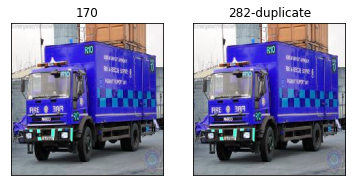

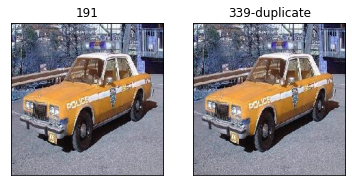

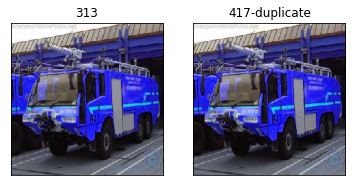

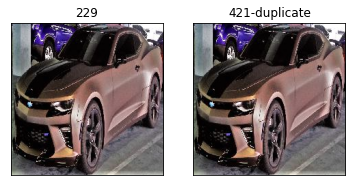

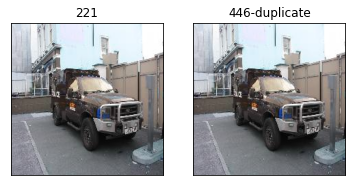

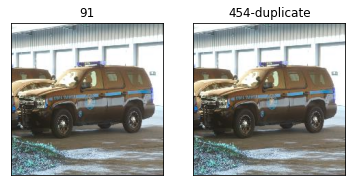

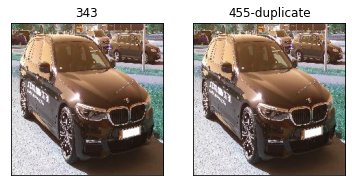

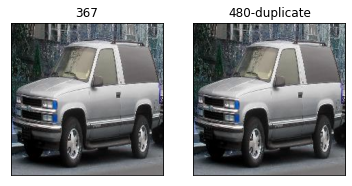

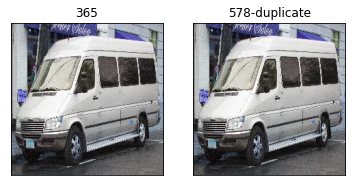

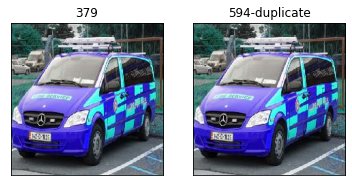

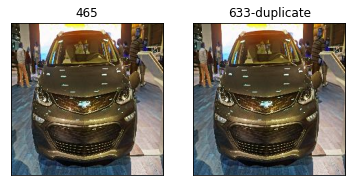

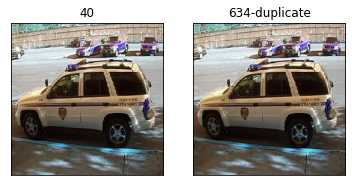

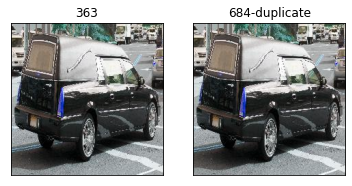

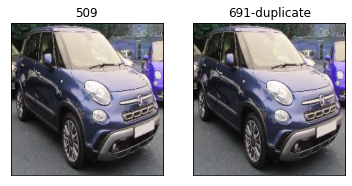

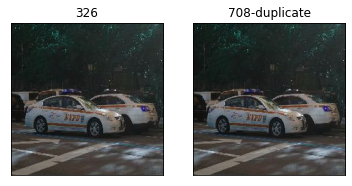

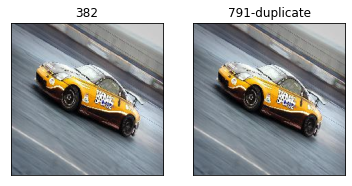

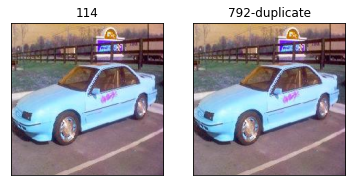

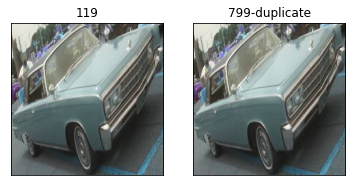

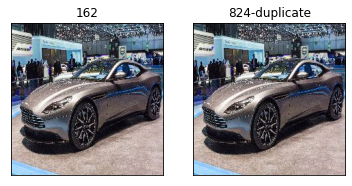

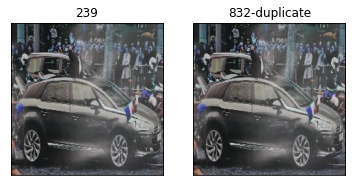

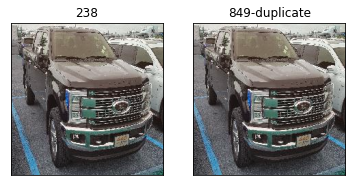

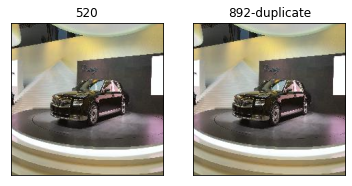

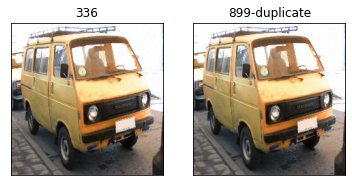

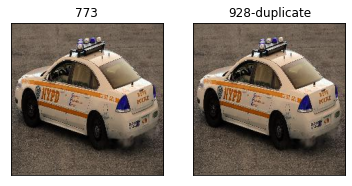

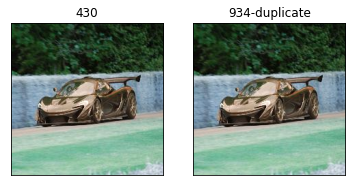

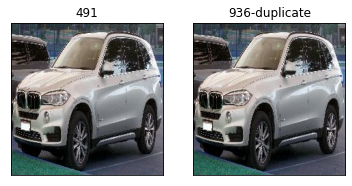

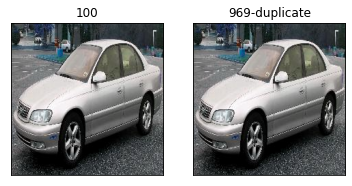

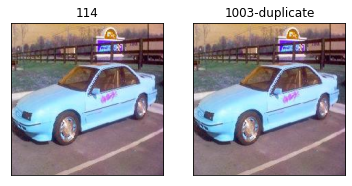

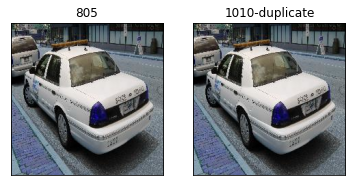

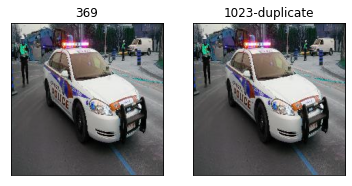

Lenght of Duplicate images : 134


In [31]:
import hashlib
#from scipy.misc import imread, imresize, imshow
from cv2 import imread
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
def file_hash(filename):
    with open(filename,'rb') as f:
        return md5(f.read()).hexdigest()

os.getcwd()
os.chdir('/content/drive/My Drive/ComputerVisionHackathon/images')
os.getcwd()

files_list = os.listdir('.')
print (len(files_list))

duplicates=[]
hash_keys=dict()
for index, filename in enumerate(os.listdir('.')):
    if os.path.isfile(filename):
        with open(filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
        if filehash not in hash_keys:
            hash_keys[filehash]=index
        else:
            duplicates.append((index,hash_keys[filehash]))
print(duplicates)
for file_indexes in duplicates[:30]:
    try:
        plt.subplot(121),plt.imshow(imread(files_list[file_indexes[1]]))
        plt.title(file_indexes[1]),plt.xticks([]),plt.yticks([])

        plt.subplot(122),plt.imshow(imread(files_list[file_indexes[0]]))
        plt.title(str(file_indexes[0])+ '-duplicate'),plt.xticks([]),plt.yticks([])
        plt.show()

    except OSError as e:
        continue
print("Lenght of Duplicate images :",len(duplicates))

In [0]:
for index in duplicates:
    os.remove(files_list[index[0]])